In [21]:
import pandas as pd

pd.set_option("display.max_columns", None)

import cufflinks as cf

# We set the all charts as public
cf.set_config_file(sharing="public", theme="pearl", offline=False)
cf.go_offline()

In [22]:
# read data
price_df = pd.read_csv("./data/forecasting.csv")
price_df.columns = price_df.columns.str.lower()
price_df["date"] = pd.to_datetime(price_df["date"])
len(price_df)

43544

## Feature Engineering

In [103]:
# engineer some features
price_df["is_apartment"] = (
    price_df["categories"].map(lambda x: "APARTMENT" in x).map(int)
)
price_df["categories"] = price_df["categories"].str.replace("APARTMENT, ", "")

price_df["is_duplex"] = price_df["categories"].map(lambda x: "DUPLEX" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("DUPLEX, ", "")


price_df["is_house"] = price_df["categories"].map(lambda x: "HOUSE" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("HOUSE, ", "")

d = {range(0, 50): "sm", range(50, 100): "md", range(100, 2000): "bg"}

price_df["size"] = price_df["space"].apply(
    lambda x: next((v for k, v in d.items() if x in k), "sm")
)

# categorize with ChatGPT
residential = [
    "DUPLEX",
    "FURNISHED_FLAT",
    "APARTMENT",
    "FLAT",
    "ROOF_FLAT",
    "ATTIC_FLAT",
    "LOFT",
    "SINGLE_ROOM",
    "STUDIO",
    "HOUSE",
    "ROW_HOUSE",
    "DUPLEX, MAISONETTE",
    "HOUSE, SINGLE_HOUSE",
    "ROW_HOUSE",
    "ATTIC",
    "BIFAMILIAR_HOUSE",
    "HOUSE, BIFAMILIAR_HOUSE",
    "TERRACE_FLAT",
    "BACHELOR_FLAT",
    "HOUSE, VILLA",
    "HOUSE, MULTIPLE_DWELLING",
    "VILLA",
]

commercial = [
    "OFFICE",
    "COMMERCIAL",
    "RETAIL, PRACTICE",
    "SHOP, ATELIER",
    "RETAIL, COMMERCIAL",
    "RESTAURANT",
    "WORKSHOP",
    "RETAIL, SHOP",
    "SHOP",
    "RESIDENTIAL_COMMERCIAL_BUILDING",
    "HOBBY_ROOM",
    "INDUSTRIAL_OBJECT",
    "STORAGE_ROOM",
    "ATELIER",
    "CAFE_BAR, RESTAURANT",
    "RETAIL, HAIRDRESSER",
    "RETAIL_SPACE, ATELIER",
    "ADVERTISING_AREA",
    "FACTORY",
    "RETAIL, STORAGE_ROOM",
    "UNDERGROUND_SLOT",
    "CAFE_BAR, BAR",
    "PRACTICE",
    "COFFEEHOUSE",
]

price_df["is_residential"] = price_df["categories"].isin(residential).map(int).fillna(0)
price_df["is_commercial"] = price_df["categories"].isin(commercial).map(int).fillna(0)

In [24]:
# remove NAs in target
print(price_df.price.isna().value_counts())
print(price_df.space.isna().value_counts())
price_df = price_df.dropna(subset=["price"])  # "space"
len(price_df)

False    37397
True      6147
Name: price, dtype: int64
False    34545
True      8999
Name: space, dtype: int64


37397

In [25]:
price_df.drop(columns=["date", "categories"]).corr().style.background_gradient(
    cmap="coolwarm"
)

/var/folders/8y/630_g50j6sg5c2q1qypy80pw0000gn/T/ipykernel_42694/4014027835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  price_df.drop(columns=["date", "categories"]).corr().style.background_gradient(


,price,space,is_apartment,is_duplex,is_house,is_residential,is_commercial
price,1.000000,0.159076,-0.042458,0.009543,0.018420,-0.044072,0.046681
space,0.159076,1.000000,-0.187060,0.247235,0.270212,-0.263992,0.154457
is_apartment,-0.042458,-0.187060,1.000000,-0.144783,-0.194864,0.711457,-0.660235
is_duplex,0.009543,0.247235,-0.144783,1.000000,-0.021266,0.027209,-0.072052
is_house,0.018420,0.270212,-0.194864,-0.021266,1.000000,-0.099882,-0.041227
is_residential,-0.044072,-0.263992,0.711457,0.027209,-0.099882,1.000000,-0.900368
is_commercial,0.046681,0.154457,-0.660235,-0.072052,-0.041227,-0.900368,1.000000


In [26]:
residential_df = price_df.query("is_residential == 1").drop(
    columns=["is_commercial", "is_residential"]
)
len(residential_df)

31582

In [27]:
residential_df.sort_values("is_apartment")

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
36571,2018-10-25,3700.0,130.0,ROW_HOUSE,0,0,1,bg
28897,2019-06-12,1050.0,35.0,FURNISHED_FLAT,0,0,0,sm
36576,2018-04-03,1400.0,85.0,ROOF_FLAT,0,0,0,md
36585,2018-05-15,799.0,25.0,FURNISHED_FLAT,0,0,0,sm
...,...,...,...,...,...,...,...,...
15013,2021-01-22,1700.0,91.0,ROOF_FLAT,1,0,0,md
15011,2021-08-11,1900.0,70.0,FLAT,1,0,0,md
15010,2021-02-05,1400.0,75.0,FLAT,1,0,0,md
15024,2021-06-16,700.0,34.0,STUDIO,1,0,0,sm


In [28]:
residential_df.join(pd.get_dummies(residential_df["categories"]).applymap(int)).drop(
    columns=["date", "categories"]
).corr().style.background_gradient(cmap="coolwarm")

/var/folders/8y/630_g50j6sg5c2q1qypy80pw0000gn/T/ipykernel_42694/4052620087.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ).corr().style.background_gradient(cmap="coolwarm")


,price,space,is_apartment,is_duplex,is_house,APARTMENT,ATTIC,ATTIC_FLAT,BACHELOR_FLAT,BIFAMILIAR_HOUSE,DUPLEX,FLAT,FURNISHED_FLAT,LOFT,ROOF_FLAT,ROW_HOUSE,SINGLE_ROOM,STUDIO,TERRACE_FLAT,VILLA
price,1.000000,0.130818,-0.040999,0.032242,0.035898,-0.027656,-0.012218,0.016550,-0.000231,0.017905,0.032242,-0.018159,0.052532,0.005107,0.006134,0.028452,-0.024823,-0.013890,0.001884,0.021388
space,0.130818,1.000000,-0.129729,0.287626,0.202538,-0.046219,-0.079560,0.077122,-0.004281,0.131518,0.287626,-0.071248,0.009600,0.048819,0.078471,0.155293,-0.223986,-0.127795,0.012588,0.094406
is_apartment,-0.040999,-0.129729,1.000000,-0.317157,-0.241076,0.304123,-0.066672,-0.138909,-0.012999,-0.108945,-0.317157,0.295703,-0.372489,-0.088829,-0.241861,-0.209258,-0.176435,-0.134332,-0.028819,-0.067531
is_duplex,0.032242,0.287626,-0.317157,1.000000,-0.017295,-0.157018,-0.009264,-0.021853,-0.002166,-0.007816,1.000000,-0.152670,-0.059082,-0.013905,-0.036903,-0.015012,-0.025787,-0.019005,-0.005630,-0.004845
is_house,0.035898,0.202538,-0.241076,-0.017295,1.000000,-0.073317,-0.004325,-0.010204,-0.001011,0.451911,-0.017295,-0.071287,-0.027587,-0.006493,-0.017231,0.868015,-0.012041,-0.008874,-0.002629,0.138929
APARTMENT,-0.027656,-0.046219,0.304123,-0.157018,-0.073317,1.000000,-0.039270,-0.092638,-0.009182,-0.033133,-0.157018,-0.647201,-0.250459,-0.058945,-0.156439,-0.063640,-0.109317,-0.080566,-0.023865,-0.020538
ATTIC,-0.012218,-0.079560,-0.066672,-0.009264,-0.004325,-0.039270,1.000000,-0.005465,-0.000542,-0.001955,-0.009264,-0.038183,-0.014776,-0.003478,-0.009229,-0.003755,-0.006449,-0.004753,-0.001408,-0.001212
ATTIC_FLAT,0.016550,0.077122,-0.138909,-0.021853,-0.010204,-0.092638,-0.005465,1.000000,-0.001278,-0.004611,-0.021853,-0.090074,-0.034857,-0.008204,-0.021772,-0.008857,-0.015214,-0.011213,-0.003321,-0.002858
BACHELOR_FLAT,-0.000231,-0.004281,-0.012999,-0.002166,-0.001011,-0.009182,-0.000542,-0.001278,1.000000,-0.000457,-0.002166,-0.008928,-0.003455,-0.000813,-0.002158,-0.000878,-0.001508,-0.001111,-0.000329,-0.000283
BIFAMILIAR_HOUSE,0.017905,0.131518,-0.108945,-0.007816,0.451911,-0.033133,-0.001955,-0.004611,-0.000457,1.000000,-0.007816,-0.032215,-0.012467,-0.002934,-0.007787,-0.003168,-0.005441,-0.004010,-0.001188,-0.001022


In [29]:
residential_df

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
1,2018-03-15,2850.0,190.0,DUPLEX,0,1,0,bg
2,2020-06-05,4600.0,170.0,FURNISHED_FLAT,1,0,0,bg
6,2018-03-13,1370.0,NaN,APARTMENT,1,0,0,sm
8,2018-11-06,1110.0,NaN,APARTMENT,1,0,0,sm
...,...,...,...,...,...,...,...,...
43537,2021-02-04,1320.0,75.0,FLAT,1,0,0,md
43538,2020-08-10,1950.0,120.0,LOFT,1,0,0,bg
43539,2020-08-14,1990.0,70.0,DUPLEX,1,1,0,md
43542,2020-08-18,1540.0,75.0,FLAT,1,0,0,md


<Axes: >

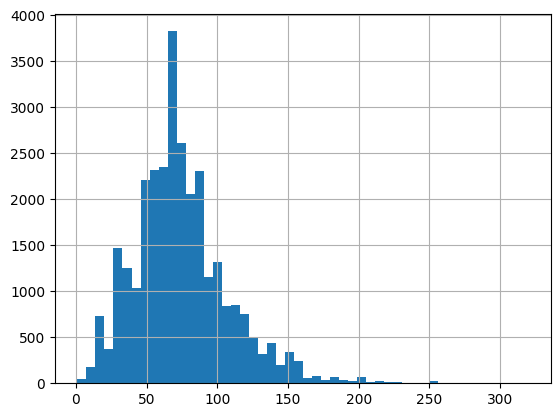

In [30]:
residential_df["space"].hist(bins=50)

## Modelling

In [104]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(
    residential_df,
    target="price",
    session_id=123,
    log_experiment=True,
    experiment_name="price_forecast",
)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(31582, 8)"
4,Transformed data shape,"(31582, 26)"
5,Transformed train set shape,"(22107, 26)"
6,Transformed test set shape,"(9475, 26)"
7,Numeric features,4
8,Date features,1
9,Categorical features,2


run `mlflow ui` in the terminal

In [105]:
best = s.compare_models(
    include=[
        "lr",
        "ridge",
        "lasso",
        "huber",
        "rf",
        "catboost",
        "lightgbm",
        "knn",
        "xgboost",
    ]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,349.1622,34433930.7886,2327.1295,0.5791,0.2821,0.2348,0.2170
ridge,Ridge Regression,349.2550,34434066.6190,2327.2324,0.5790,0.2820,0.2349,0.0220
lasso,Lasso Regression,350.1105,34436463.9904,2328.7818,0.5770,0.2831,0.2357,0.0280
huber,Huber Regressor,340.6559,34454901.5832,2343.5986,0.5569,0.2758,0.2184,0.0830
catboost,CatBoost Regressor,357.9713,35734663.5042,2822.0438,-1.1054,0.2974,0.2620,0.5300
knn,K Neighbors Regressor,378.7605,37197061.6672,2992.0234,-2.7569,0.2867,0.2797,0.0580
lightgbm,Light Gradient Boosting Machine,442.0202,37542536.9674,3445.5523,-3.4395,0.3760,0.3334,0.3760
rf,Random Forest Regressor,358.0564,41645995.7756,3604.1463,-9.6134,0.2651,0.2391,0.5650
xgboost,Extreme Gradient Boosting,353.3843,58061869.8422,3999.4082,-33.5730,0.2583,0.2465,0.0490


In [106]:
print(best)

LinearRegression(n_jobs=-1)


In [107]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

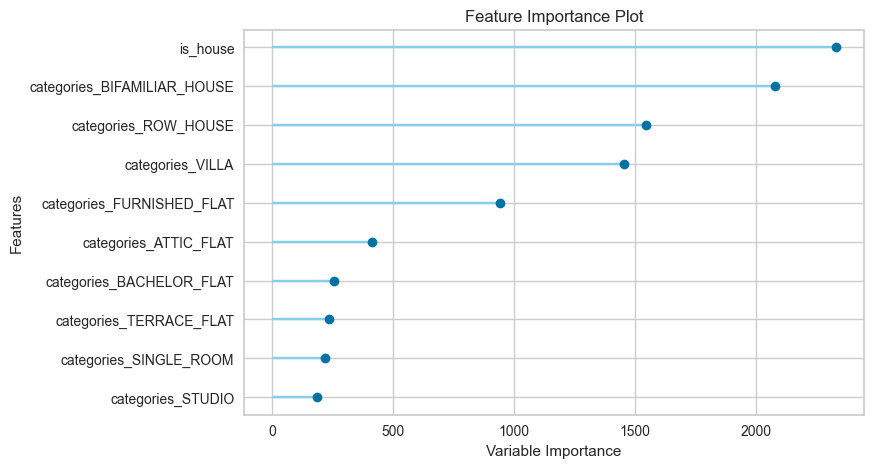

In [108]:
s.plot_model(
    best,
    plot="feature",
)

In [109]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,304.6656,237831.7255,487.6799,0.6859,0.2604,0.2047


,date,space,categories,is_apartment,is_duplex,is_house,size,price,prediction_label
34346,2020-03-11,60.0,FLAT,1,0,0,md,1220.0,1384.637613
30106,2019-09-30,105.0,APARTMENT,1,0,0,bg,2790.0,2166.754530
28664,2019-11-06,128.0,ATTIC_FLAT,0,0,0,bg,2880.0,3081.387911
39871,2019-08-07,158.0,DUPLEX,0,1,0,bg,2650.0,3160.361971
35500,2019-01-22,81.0,APARTMENT,1,0,0,md,1450.0,1495.122299
...,...,...,...,...,...,...,...,...,...
1404,2020-06-02,86.0,FLAT,1,0,0,md,1950.0,1900.814004
40436,2021-10-22,31.0,FLAT,1,0,0,sm,700.0,799.810315
40129,2021-01-04,35.0,FLAT,1,0,0,sm,1000.0,829.831389
26537,2018-08-20,NaN,APARTMENT,1,0,0,sm,1220.0,1476.656701


In [121]:
mdl = s.create_model("lr")
tuned_model = s.tune_model(mdl, optimize="RMSE", search_library="scikit-optimize")
s.evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,311.8760,2062104.2500,1436.0029,-1.6998,0.2597,0.2129
1,286.5372,453844.8750,673.6801,0.4151,0.2861,0.5098
2,284.5359,588220.3125,766.9552,0.4860,0.2612,0.1902
3,669.6142,341687584.0000,18484.7930,0.0002,0.2760,0.1765
4,271.1600,199669.6562,446.8441,0.6904,0.2460,0.1858
5,274.9736,197996.4531,444.9679,0.7449,0.2584,0.1983
6,260.7278,184903.4375,430.0040,0.7356,0.2411,0.1828
7,600.9196,232475552.0000,15247.1494,-336.0075,0.2717,0.4331
8,304.4755,2551284.2500,1597.2740,-1.8034,0.2437,0.1976


ModuleNotFoundError: 
'skopt' is a soft dependency and not included in the pycaret installation. Please run: `pip install scikit-optimize` to install.
Alternately, you can install this by running `pip install pycaret[tuners]`

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,308.6646,246935.8125,496.9264,0.6739,0.2655,0.2140


,date,space,categories,is_apartment,is_duplex,is_house,size,price,prediction_label
34346,2020-03-11,60.0,FLAT,1,0,0,md,1220.0,1428.913208
30106,2019-09-30,105.0,APARTMENT,1,0,0,bg,2790.0,2293.295410
28664,2019-11-06,128.0,ATTIC_FLAT,0,0,0,bg,2880.0,2878.078369
39871,2019-08-07,158.0,DUPLEX,0,1,0,bg,2650.0,3410.446045
35500,2019-01-22,81.0,APARTMENT,1,0,0,md,1450.0,1597.831421
...,...,...,...,...,...,...,...,...,...
1404,2020-06-02,86.0,FLAT,1,0,0,md,1950.0,1753.320068
40436,2021-10-22,31.0,FLAT,1,0,0,sm,700.0,932.196594
40129,2021-01-04,35.0,FLAT,1,0,0,sm,1000.0,885.017578
26537,2018-08-20,NaN,APARTMENT,1,0,0,sm,1220.0,1343.855469


In [119]:
s.predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,308.6646,246935.8125,496.9264,0.6739,0.2655,0.2140


,date,space,categories,is_apartment,is_duplex,is_house,size,price,prediction_label
34346,2020-03-11,60.0,FLAT,1,0,0,md,1220.0,1428.913208
30106,2019-09-30,105.0,APARTMENT,1,0,0,bg,2790.0,2293.295410
28664,2019-11-06,128.0,ATTIC_FLAT,0,0,0,bg,2880.0,2878.078369
39871,2019-08-07,158.0,DUPLEX,0,1,0,bg,2650.0,3410.446045
35500,2019-01-22,81.0,APARTMENT,1,0,0,md,1450.0,1597.831421
...,...,...,...,...,...,...,...,...,...
1404,2020-06-02,86.0,FLAT,1,0,0,md,1950.0,1753.320068
40436,2021-10-22,31.0,FLAT,1,0,0,sm,700.0,932.196594
40129,2021-01-04,35.0,FLAT,1,0,0,sm,1000.0,885.017578
26537,2018-08-20,NaN,APARTMENT,1,0,0,sm,1220.0,1343.855469


## Model Price per square meter

In [97]:
ts_df = residential_df.dropna(subset=["space"]).reset_index(drop=True)
ts_df["price_sqm"] = ts_df.eval("price/space").map(lambda x: int(x * 100) / 100)
ts_df = ts_df.join(pd.get_dummies(ts_df["categories"]).applymap(int))
ts_df.shape

(30148, 24)

In [99]:
ts_df.set_index("date")["price_sqm"].resample("M").mean().iplot()

In [100]:
ts_df = ts_df.sort_values("price_sqm").query("price_sqm<=200").reset_index(drop=True)

In [101]:
ts_df.set_index("date")["price_sqm"].resample("M").mean().iplot()

In [93]:
ts_df.query("is_duplex==1").groupby(pd.to_datetime(ts_df.date.dt.strftime("%Y-%m-01")))[
    "price_sqm"
].mean().iplot()

,date,price,space,categories,is_apartment,is_duplex,is_house,size,price_sqm,APARTMENT,ATTIC,ATTIC_FLAT,BACHELOR_FLAT,BIFAMILIAR_HOUSE,DUPLEX,FLAT,FURNISHED_FLAT,LOFT,ROOF_FLAT,ROW_HOUSE,SINGLE_ROOM,STUDIO,TERRACE_FLAT,VILLA
13194,2021-10-05,28896.0,29.0,FLAT,1,0,0,sm,996.41,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3997,2020-05-13,1383.0,1.0,FLAT,1,0,0,sm,1383.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10589,2020-11-27,1400.0,1.0,FLAT,1,0,0,sm,1400.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3714,2018-04-12,1480.0,1.0,APARTMENT,1,0,0,sm,1480.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17250,2018-06-11,1560.0,1.0,APARTMENT,1,0,0,sm,1560.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29517,2018-06-11,1560.0,1.0,APARTMENT,1,0,0,sm,1560.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27697,2018-11-28,1950.0,1.0,ROOF_FLAT,0,0,0,sm,1950.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24531,2020-10-07,870150.0,59.0,FLAT,1,0,0,md,14748.30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
